### EasyOCR

In [ ]:
import easyocr

#Carga del modelo de lengua
reader = easyocr.Reader(['es']) 

#Reconocimiento de una imagen
res = reader.readtext('ocr_test.tif')

for (bbox, text, prob) in res:
    # Coordenadas en orden 
    (top_left, top_right, bottom_right, bottom_left) = bbox
    print(f'\nTexto: {text}\nProbabilidad: {prob:.2f}\nContenedor: {tuple(map(int, top_left)),tuple(map(int, bottom_right))}')


#Con restricción de caracteres reconocibles
#result = reader.readtext('toy.tif', allowlist ='0123456789')

### Tesseract

In [37]:
# Tesseract
import cv2
import pytesseract
from pytesseract import Output

# Previamente debes descargar los ejecutables
# Si la ruta de Tesseract no está en el PATH, ruta al ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'

# Lenguajes disponibles
print(pytesseract.get_languages(config=''))

#Cargo imagen y ocnvierto a RGB
img = cv2.imread('ocr_test.tif') 

if img is not None:
    #Convierte a RGB antes de procesar
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Texto localizado
    print(pytesseract.image_to_string(img))

    #Texto y localización en imagen de cada palabra
    d = pytesseract.image_to_data(img_rgb, output_type=Output.DICT)

    n_boxes = len(d['text'])
    for i in range(n_boxes):
        #Nivel de confianza
        if int(d['conf'][i]) > 60:
            text = d['text'][i]
            conf = d['conf'][i]
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

            print(f'Texto: {text} ({conf:.2f}%)\nContenedor: {x,y,x+w,y+h}')

    cv2.imshow('img', img_rgb)
    cv2.waitKey(-1)

   

else:
    print('Error de imagen')

['eng', 'osd']
Hasta el infinito y mas alla

Texto: Hasta (96.00%)
Contenedor: (57, 95, 176, 130)
Texto: el (93.00%)
Contenedor: (194, 95, 226, 130)
Texto: infinito (91.00%)
Contenedor: (246, 95, 380, 130)
Texto: y (92.00%)
Contenedor: (408, 104, 418, 140)
Texto: mas (96.00%)
Contenedor: (435, 94, 521, 130)
Texto: alla (96.00%)
Contenedor: (538, 94, 609, 130)


### PaddleOCR

In [ ]:
from paddleocr import PaddleOCR 


ocr = PaddleOCR(use_angle_cls=True, lang='en')  # need to run only once to download and load model into memory
img_path = 'matricula.jpg'
result = ocr.predict(img_path)[0]

print(result['rec_texts'], result['rec_scores'])

### SmolVLM

In [ ]:
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch
Device = "cpu"  # or "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained("HuggingFaceTB/SmolVLM-Instruct",
                                                dtype=torch.bfloat16,
                                                _attn_implementation="flash_attention_2" if Device == "cuda" else "eager").to(Device)


In [ ]:
from PIL import Image
from transformers.image_utils import load_image
from matplotlib import pyplot as plt

# Load images

image_1 = Image.open('matricula.jpg')
# Create input messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you give me the text in the license plate of the image?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=prompt, images=[image_1], return_tensors="pt")
inputs = inputs.to(Device)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_texts = processor.batch_decode(
    generated_ids,
    skip_special_tokens=True,
)

plt.imshow(image_1)
plt.axis('off')
plt.show()
print(generated_texts[0])

Usando dispositivo: CUDA
Cargando modelo YOLO...
Modelos cargados

Matrícula (conf=0.98):
  EasyOCR → JBF'4509 → 4509JBF
  Tesseract →  →  (0 válidas de 1)
  FINAL → 4509JBF [EasyOCR]


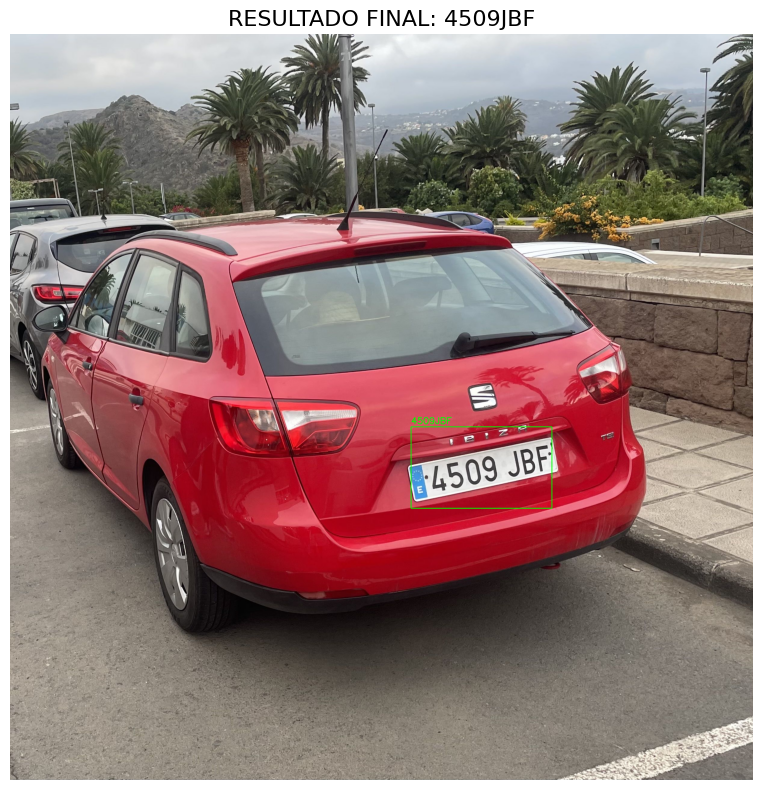


FORMATO ESPAÑOL VÁLIDO: 4509JBF


In [5]:
"""
YOLO + OCR → Matrículas españolas (4 números + 3 letras)
→ EasyOCR: líder (funciona)
→ Tesseract: CORREGIDO → detecta todo
→ SIN invertir, SIN juntar, SIN recorte vertical en Tesseract
"""

import cv2
import pytesseract
from pytesseract import Output
import easyocr
from ultralytics import YOLO
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# =================== CONFIG ===================
IMAGE_PATH = "./coche-prueba.jpg"
PLATE_MODEL = "../P4/best.pt"
CONF_THRESHOLD = 0.25
OCR_LANG = "en"
TESSERACT_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
OUTPUT_CROPS_DIR = "output_crops"
# ==============================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device.upper()}")

pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH
os.makedirs(OUTPUT_CROPS_DIR, exist_ok=True)

print("Cargando modelo YOLO...")
model_plate = YOLO(PLATE_MODEL).to(device)
reader = easyocr.Reader([OCR_LANG], gpu=(device == 'cuda'))
print("Modelos cargados")

# =================== UTILIDADES ===================
def clean_text(text):
    return re.sub(r"[^A-Z0-9]", "", text.upper())

def fix_ocr_errors(text):
    text = text.replace('O', '0').replace('I', '1').replace('L', '1')
    text = text.replace('S', '5').replace('Z', '2').replace('T', '7')
    return text

def postprocess_8_to_B(text):
    if re.match(r'^\d{4}[A-Z0-9]{3}$', text):
        letters = text[-3:]
        if '8' in letters and letters.replace('8', 'B').isalpha():
            text = text[:-3] + letters.replace('8', 'B')
    return text

def normalize_spanish_plate(text):
    text = clean_text(text)
    text = fix_ocr_errors(text)
    text = postprocess_8_to_B(text)

    valid_letters = 'BCDFGHJKLMNPRSTVWXYZ'
    nums = ''.join(c for c in text if c.isdigit())
    lets = ''.join(c for c in text if c in valid_letters)

    if len(nums) >= 4 and len(lets) >= 3:
        return nums[:4] + lets[:3]  # SIN INVERTIR
    return text

# =================== PROCESAMIENTO ===================
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"No se encuentra: {IMAGE_PATH}")

results = model_plate.predict(img, conf=CONF_THRESHOLD, verbose=False)
final_text = "NO_DETECTADA"

for r in results:
    for i, box in enumerate(r.boxes):
        cls_id = int(box.cls[0])
        tipo = model_plate.names[cls_id].lower()
        if tipo not in ["class0", "matricula", "license_plate"]:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        conf = float(box.conf)
        crop = img[y1:y2, x1:x2].copy()
        if crop.size == 0:
            continue

        h, w = crop.shape[:2]

        # --- Corte franja azul ---
        scan_w = int(0.35 * w)
        hsv = cv2.cvtColor(crop[:, :scan_w], cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, (95, 60, 40), (140, 255, 255))
        xs = np.where(mask.any(axis=0))[0]
        cut_x = 0
        if xs.size > 0:
            cut_x = min(int(np.percentile(xs, 90)) + 6, int(0.4 * w))
        crop = crop[:, cut_x:]

        # --- IMÁGENES SEPARADAS ---
        crop_easy = crop[int(0.15*h):int(0.85*h), :]  # Para EasyOCR
        crop_tess = crop.copy()  # ¡COMPLETA para Tesseract!

        # --- PREPROCESADO (solo EasyOCR) ---
        gray = cv2.cvtColor(crop_easy, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
        gray = cv2.GaussianBlur(gray, (5,5), 0)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        if np.mean(thresh) > 127:
            thresh = cv2.bitwise_not(thresh)

        # --- EASYOCR ---
        easy_raw = ""
        for (_, text, conf) in reader.readtext(thresh, detail=1):
            if conf > 0.5:
                easy_raw += text.upper()
        easy_text = normalize_spanish_plate(easy_raw)

        # --- TESSERACT con idioma ESPAÑOL ---
        tess_config = '--oem 3 --psm 7 -l spa -c tessedit_char_whitelist=0123456789BCDFGHJKLMNPRSTVWXYZ'
        crop_rgb = cv2.cvtColor(crop_tess, cv2.COLOR_BGR2RGB)  # ¡COMPLETO!

        d = pytesseract.image_to_data(crop_rgb, config=tess_config, output_type=Output.DICT)

        tess_raw = ""
        n_boxes = len(d['text'])
        valid_boxes = 0
        for j in range(n_boxes):
            conf_val = int(d['conf'][j])
            text = d['text'][j].strip()
            if conf_val > 60 and text:
                tess_raw += text.upper()
                valid_boxes += 1
                (x, y, w_box, h_box) = (d['left'][j], d['top'][j], d['width'][j], d['height'][j])
                cv2.rectangle(crop_tess, (x, y), (x + w_box, y + h_box), (0, 255, 0), 1)
                cv2.putText(crop_tess, f"{conf_val}%", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

        tess_text = normalize_spanish_plate(tess_raw)

        # --- VOTACIÓN ---
        pattern = r'^\d{4}[BCDFGHJKLMNPRSTVWXYZ]{3}$'
        if re.match(pattern, easy_text):
            final_text = easy_text
            source = "EasyOCR"
        elif re.match(pattern, tess_text):
            final_text = tess_text
            source = "Tesseract"
        else:
            final_text = easy_text if len(easy_text) >= len(tess_text) else tess_text
            source = "Fallback"

        # --- IMPRESIÓN ---
        print(f"\nMatrícula (conf={conf:.2f}):")
        print(f"  EasyOCR → {easy_raw} → {easy_text}")
        print(f"  Tesseract → {tess_raw} → {tess_text} ({valid_boxes} válidas de {n_boxes})")
        print(f"  FINAL → {final_text} [{source}]")

        # --- DIBUJAR EN IMAGEN ORIGINAL ---
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, final_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # --- GUARDAR DEBUG ---
        cv2.imwrite(f"{OUTPUT_CROPS_DIR}/easy_input_{i}.png", thresh)
        cv2.imwrite(f"{OUTPUT_CROPS_DIR}/tess_input_{i}.png", crop_tess)

# =================== VISUALIZACIÓN FINAL ===================
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"RESULTADO FINAL: {final_text}", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

# Validación final
if re.match(r'^\d{4}[BCDFGHJKLMNPRSTVWXYZ]{3}$', final_text):
    print(f"\nFORMATO ESPAÑOL VÁLIDO: {final_text}")
else:
    print(f"\nFORMATO NO VÁLIDO: {final_text}")

In [7]:
"""
PIPELINE GPU OPTIMIZADO - DETECCIÓN Y LECTURA DE MATRÍCULAS EN VIDEO
Combina detección YOLO + OCR (EasyOCR y Tesseract) para leer matrículas

Características:
- YOLO11n para detección general + YOLO especializado para matrículas
- EasyOCR + Tesseract para leer texto de matrículas
- Blur opcional (desactivado por defecto para visualizar)
- OCR solo en matrículas detectadas
- Resultados en CSV con texto leído (CORREGIDO: ahora incluye cacheados)
"""

# ========================= CONFIG =========================
VIDEO_IN_PATH = "C0142.MP4"
VIDEO_OUT_PATH = "outputs/salida_con_ocr.mp4"
CSV_OUT_PATH = "outputs/detecciones_ocr.csv"

GENERAL_MODEL = r"C:\Users\User\VC-ULPGC\VC_P4\P4\yolo11n.pt"
PLATE_MODEL = r"C:\Users\User\VC-ULPGC\VC_P4\P4\best.pt"

CONF_THRESHOLD = 0.25
BLUR_PLATES = False  # False para ver las matrículas, True para difuminarlas
BLUR_INTENSITY = 61
OCR_EVERY_N_FRAMES = 3  # Hacer OCR cada N frames para optimizar
TESSERACT_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
# ============================================================

import os, csv, cv2, torch, re, time
import numpy as np
from ultralytics import YOLO
from collections import defaultdict
import easyocr
import pytesseract

pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH

# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n[INFO] Dispositivo: {device.upper()}")
if device == 'cuda':
    print(f"[INFO] GPU: {torch.cuda.get_device_name(0)}")

os.makedirs("outputs", exist_ok=True)

# Modelos
print("[INFO] Cargando YOLO...")
model_general = YOLO(GENERAL_MODEL).to(device)
model_plate = YOLO(PLATE_MODEL).to(device)

print("[INFO] Inicializando EasyOCR...")
reader = easyocr.Reader(['en'], gpu=(device == 'cuda'), verbose=False)
print("[INFO] Modelos listos\n")

# Clases
classNames = ["person", "bicycle", "car", "motorbike", "bus", "truck"]
VEHICLE_CLASSES = {"car", "bus", "truck", "motorbike", "bicycle"}

# ====== FUNCIONES OCR ======
def clean_text(text):
    """Limpia texto dejando solo alfanuméricos"""
    return re.sub(r"[^A-Z0-9]", "", text.upper())

def fix_common_errors(text):
    """Corrige errores OCR comunes"""
    text = text.replace('O', '0').replace('I', '1').replace('L', '1')
    text = text.replace('S', '5').replace('Z', '2')
    return text

def normalize_plate(text):
    """Normaliza matrícula española"""
    text = clean_text(text)
    text = fix_common_errors(text)
    
    valid_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    nums = ''.join(c for c in text if c.isdigit())
    lets = ''.join(c for c in text if c in valid_letters)
    
    # Formato estándar: 4 números + 3 letras
    if len(nums) >= 4 and len(lets) >= 3:
        return nums[:4] + lets[:3]
    
    # Formato Canarias: 2 letras + 4 números + 2 letras
    if len(lets) >= 4 and len(nums) >= 4:
        return lets[:2] + nums[:4] + lets[2:4]
    
    # Formato antiguo: 1 letra + 4 números + 3 letras
    if len(lets) >= 4 and len(nums) >= 4:
        return lets[0] + nums[:4] + lets[1:4]
    
    return text

def read_plate_ocr(crop):
    """Lee matrícula usando EasyOCR y Tesseract"""
    if crop.size == 0 or crop.shape[0] < 20 or crop.shape[1] < 40:
        return "", "none", 0.0
    
    # Preprocesar: resize x3
    crop_resized = cv2.resize(crop, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    
    # --- EasyOCR ---
    easy_text = ""
    easy_conf = 0.0
    try:
        results = reader.readtext(crop_resized, paragraph=True, detail=1)
        if results:
            best = max(results, key=lambda x: x[2])
            easy_text = best[1].upper()
            easy_conf = float(best[2])
    except:
        pass
    
    # --- Tesseract ---
    tess_text = ""
    try:
        gray = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2GRAY)
        _, enhanced = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        tess_config = '--oem 1 --psm 7 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        tess_text = pytesseract.image_to_string(enhanced, config=tess_config).strip().upper()
    except:
        pass
    
    # Normalizar ambos
    easy_norm = normalize_plate(easy_text)
    tess_norm = normalize_plate(tess_text)
    
    # Elegir el mejor
    if len(easy_norm) >= len(tess_norm) and len(easy_norm) >= 6:
        return easy_norm, "easyocr", easy_conf
    elif len(tess_norm) >= 6:
        return tess_norm, "tesseract", 0.8
    elif len(easy_norm) > 0:
        return easy_norm, "easyocr", easy_conf
    else:
        return tess_norm if tess_norm else "", "none", 0.0

# ====== FUNCIONES AUXILIARES ======
def blur_region(img, x1, y1, x2, y2, intensity=BLUR_INTENSITY):
    """Aplica blur controlando límites"""
    h, w = img.shape[:2]
    x1, y1, x2, y2 = map(int, [max(0, x1), max(0, y1), min(w, x2), min(h, y2)])
    if x2 <= x1 or y2 <= y1:
        return img
    roi = img[y1:y2, x1:x2]
    k = intensity if (x2 - x1) > 30 else 15
    k = k if k % 2 == 1 else k + 1
    blurred = cv2.GaussianBlur(roi, (k, k), 0)
    img[y1:y2, x1:x2] = blurred
    return img

def smooth_coords(prev, new, alpha=0.5):
    """Suavizado exponencial de coordenadas"""
    if prev is None:
        return new
    return tuple(int(p * (1 - alpha) + n * alpha) for p, n in zip(prev, new))

# ====== VIDEO ======
cap = cv2.VideoCapture(VIDEO_IN_PATH)
width, height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(5) or 25
total_frames = int(cap.get(7))

out = cv2.VideoWriter(VIDEO_OUT_PATH, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

# ====== CSV ======
csv_file = open(CSV_OUT_PATH, "w", newline="", encoding="utf-8")
writer = csv.writer(csv_file)
writer.writerow(["frame", "tipo_objeto", "confianza", "id_tracking",
                 "x1", "y1", "x2", "y2",
                 "matricula_detectada", "conf_matricula",
                 "texto_matricula", "metodo_ocr", "conf_ocr",
                 "mx1", "my1", "mx2", "my2"])

# ====== TRACKING ======
results_stream = model_general.track(
    source=VIDEO_IN_PATH,
    tracker="botsort.yaml",
    stream=True,
    device=device,
    classes=[0, 1, 2, 3, 5, 7],
    verbose=False
)

total_detections = defaultdict(set)
plate_tracker = {}  # {track_id: {"pos": (x1,y1,x2,y2), "text": "1234ABC", "method": "easyocr", "last_read": frame, "last_conf": 0.85}}
frame_id = 0

# Variables para panel de estadísticas (como tu compañero)
ids_unicos_personas = set()
ids_unicos_coches = set()
ids_unicos_matriculas = set()
total_detecciones_matriculas = 0
matriculas_video = []  # Para OCR posterior

print(f"[INFO] Procesando {total_frames} frames...\n")

# ============================================================
# LOOP PRINCIPAL
# ============================================================
for res in results_stream:
    frame_id += 1
    frame = res.orig_img.copy()
    boxes = res.boxes

    # Frame de salida con dibujos
    frame_out = frame.copy()

    for box in boxes:
        cls_id = int(box.cls)
        if cls_id >= len(classNames):
            continue
        label = classNames[cls_id]

        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
        conf = float(box.conf)
        track_id = int(box.id) if box.id is not None else -1

        # Conteo acumulado
        if track_id != -1:
            total_detections[label].add(track_id)
            if label == "person":
                ids_unicos_personas.add(track_id)
            elif label in ["car", "bus", "truck", "motorbike"]:
                ids_unicos_coches.add(track_id)

        # ===== PERSONAS =====
        if label == "person":
            frame_out = blur_region(frame_out, x1, y1, x2, y2)
            cv2.rectangle(frame_out, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame_out, f"Person {track_id}", (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            continue

        # ===== VEHÍCULOS =====
        if label in VEHICLE_CLASSES:
            mx1 = my1 = mx2 = my2 = -1
            plate_conf = 0.0
            plate_found = False
            plate_text = ""
            ocr_method = "none"
            ocr_conf = 0.0

            crop = frame[y1:y2, x1:x2]
            if crop.size > 0:
                # Detección con YOLO
                lp_res = model_plate.predict(crop, conf=CONF_THRESHOLD, device=device, verbose=False)
                if len(lp_res[0].boxes) > 0:
                    best_box = max(lp_res[0].boxes, key=lambda b: b.conf)
                    lx1, ly1, lx2, ly2 = map(int, best_box.xyxy[0].cpu().numpy())
                    plate_conf = float(best_box.conf)
                    mx1, my1, mx2, my2 = x1 + lx1, y1 + ly1, x1 + lx2, y1 + ly2
                    plate_found = True
                    total_detecciones_matriculas += 1
                    ids_unicos_matriculas.add(track_id)

                    # Guardar recorte para OCR posterior
                    plate_crop = crop[ly1:ly2, lx1:lx2]
                    if plate_crop.size > 0:
                        matriculas_video.append({
                            'imagen': plate_crop.copy(),
                            'id': track_id,
                            'frame': frame_id
                        })

                    # Leer matrícula con OCR (solo cada N frames)
                    should_read = False
                    if track_id != -1:
                        last_read = plate_tracker.get(track_id, {}).get("last_read", 0)
                        if frame_id - last_read >= OCR_EVERY_N_FRAMES:
                            should_read = True
                    else:
                        should_read = (frame_id % OCR_EVERY_N_FRAMES == 0)
                    
                    if should_read:
                        plate_text, ocr_method, ocr_conf = read_plate_ocr(plate_crop)
                        
                        # Guardar en tracker (incluye confianza)
                        if track_id != -1:
                            if track_id not in plate_tracker:
                                plate_tracker[track_id] = {}
                            plate_tracker[track_id].update({
                                "text": plate_text,
                                "method": ocr_method,
                                "last_read": frame_id,
                                "last_conf": ocr_conf,
                                "pos": (mx1, my1, mx2, my2)
                            })
                    else:
                        # Usar texto anterior si existe
                        if track_id != -1 and track_id in plate_tracker:
                            cached = plate_tracker[track_id]
                            plate_text = cached.get("text", "")
                            ocr_method = "cached"
                            ocr_conf = cached.get("last_conf", 0.0)

            # --- Suavizado de coordenadas ---
            if track_id != -1 and plate_found:
                prev = plate_tracker.get(track_id, {}).get("pos")
                new_coords = (mx1, my1, mx2, my2)
                smoothed = smooth_coords(prev, new_coords) if prev else new_coords
                mx1, my1, mx2, my2 = smoothed
                if track_id in plate_tracker:
                    plate_tracker[track_id]["pos"] = smoothed

            # --- Visualización ---
            if plate_found and mx1 >= 0:
                if BLUR_PLATES:
                    frame_out = blur_region(frame_out, mx1, my1, mx2, my2)
                
                cv2.rectangle(frame_out, (mx1, my1), (mx2, my2), (0, 255, 0), 2)
                
                if plate_text:
                    cv2.putText(frame_out, plate_text, (mx1, my1 - 8),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            # --- Caja del vehículo ---
            cv2.rectangle(frame_out, (x1, y1), (x2, y2), (0, 128, 255), 2)
            label_text = f"{label} {track_id}"
            if plate_text:
                label_text += f" [{plate_text}]"
            cv2.putText(frame_out, label_text, (x1, y1 - 8),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 128, 255), 2)

            # ===== ESCRIBIR EN CSV (incluso si es cacheado) =====
            writer.writerow([
                frame_id, label, round(conf, 3), track_id,
                x1, y1, x2, y2,
                int(plate_found), round(plate_conf, 3),
                plate_text, ocr_method, round(ocr_conf, 3),
                mx1, my1, mx2, my2
            ])

    # DIBUJAR PANEL DE ESTADÍSTICAS (como tu compañero)
    panel_height = 130
    overlay = frame_out.copy()
    cv2.rectangle(overlay, (10, 10), (400, panel_height), (0, 0, 0), -1)
    cv2.addWeighted(overlay, 0.6, frame_out, 0.4, 0, frame_out)
    
    y_offset = 35
    cv2.putText(frame_out, f"OBJETOS UNICOS DETECTADOS:", (20, y_offset),
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    y_offset += 30
    cv2.putText(frame_out, f"Personas: {len(ids_unicos_personas)}", (20, y_offset),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    
    y_offset += 30
    cv2.putText(frame_out, f"Coches: {len(ids_unicos_coches)}", (20, y_offset),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    y_offset += 30
    cv2.putText(frame_out, f"Matriculas: {len(ids_unicos_matriculas)}", (20, y_offset),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    out.write(frame_out)

    # Progreso
    if frame_id % 100 == 0:
        print(f"[INFO] Procesados {frame_id}/{total_frames} frames ({frame_id*100//total_frames}%)")

cap.release()
out.release()
csv_file.close()

# ============================================================
# RESULTADOS FINALES 
# ============================================================
print("\n   Procesamiento completado!")
print(f"   Vídeo guardado en: {VIDEO_OUT_PATH}\n")
print(f"   ESTADÍSTICAS FINALES:")
print(f"   Total frames procesados: {frame_id}")
print(f"   Personas únicas (IDs únicos): {len(ids_unicos_personas)}")
print(f"   Coches únicos (IDs únicos): {len(ids_unicos_coches)}")
print(f"   Matrículas únicas (IDs únicos): {len(ids_unicos_matriculas)}")
print(f"   Total detecciones de matrículas: {total_detecciones_matriculas}")
print(f"   Promedio detecciones por frame: {total_detecciones_matriculas/frame_id:.2f} matrículas")
print(f"\n   Imágenes de matrículas extraídas: {len(matriculas_video)}")
print(f"   (Listas para análisis OCR en Parte 2)")


[INFO] Dispositivo: CUDA
[INFO] GPU: NVIDIA GeForce RTX 4060 Laptop GPU
[INFO] Cargando YOLO...
[INFO] Inicializando EasyOCR...
[INFO] Modelos listos

[INFO] Procesando 2832 frames...

[INFO] Procesados 100/2832 frames (3%)
[INFO] Procesados 200/2832 frames (7%)
[INFO] Procesados 300/2832 frames (10%)
[INFO] Procesados 400/2832 frames (14%)
[INFO] Procesados 500/2832 frames (17%)
[INFO] Procesados 600/2832 frames (21%)
[INFO] Procesados 700/2832 frames (24%)
[INFO] Procesados 800/2832 frames (28%)
[INFO] Procesados 900/2832 frames (31%)
[INFO] Procesados 1000/2832 frames (35%)
[INFO] Procesados 1100/2832 frames (38%)
[INFO] Procesados 1200/2832 frames (42%)
[INFO] Procesados 1300/2832 frames (45%)
[INFO] Procesados 1400/2832 frames (49%)
[INFO] Procesados 1500/2832 frames (52%)
[INFO] Procesados 1600/2832 frames (56%)
[INFO] Procesados 1700/2832 frames (60%)
[INFO] Procesados 1800/2832 frames (63%)
[INFO] Procesados 1900/2832 frames (67%)
[INFO] Procesados 2000/2832 frames (70%)
[INFO

Usando dispositivo: CUDA
Cargando YOLO...
✓ YOLO cargado
Cargando EasyOCR...
✓ EasyOCR cargado

Buscando imágenes con labels correspondientes...

✓ Encontradas 57 imágenes con labels correspondientes

[1/57] 0116GPD.jpg
  GT: 0116GPD | YOLO conf: 0.63
  EasyOCR:   0116GPD      ✓  (Acc: 100.0%, 0.155s)
  Tesseract:              ✗  (Acc:   0.0%, 0.044s)

[2/57] 0116HGV.jpg
  GT: 0116HGV | YOLO conf: 0.29
  EasyOCR:   4T6HGV       ✗  (Acc:   0.0%, 0.079s)
  Tesseract:              ✗  (Acc:   0.0%, 0.066s)

[3/57] 0290KWT.jpg
  GT: 0290KWT | YOLO conf: 0.74
  EasyOCR:   0290KWT      ✓  (Acc: 100.0%, 0.137s)
  Tesseract:              ✗  (Acc:   0.0%, 0.074s)

[4/57] 0303BML.jpg
  GT: 0303BML | YOLO conf: 0.68
  EasyOCR:   00303BM1     ✗  (Acc:  12.5%, 0.134s)
  Tesseract:              ✗  (Acc:   0.0%, 0.060s)

    ⚠ No se detectó matrícula
[6/57] 0476MNN.jpg
  GT: 0476MNN | YOLO conf: 0.62
  EasyOCR:   0476MNN      ✓  (Acc: 100.0%, 0.202s)
  Tesseract:              ✗  (Acc:   0.0%, 0.082s)


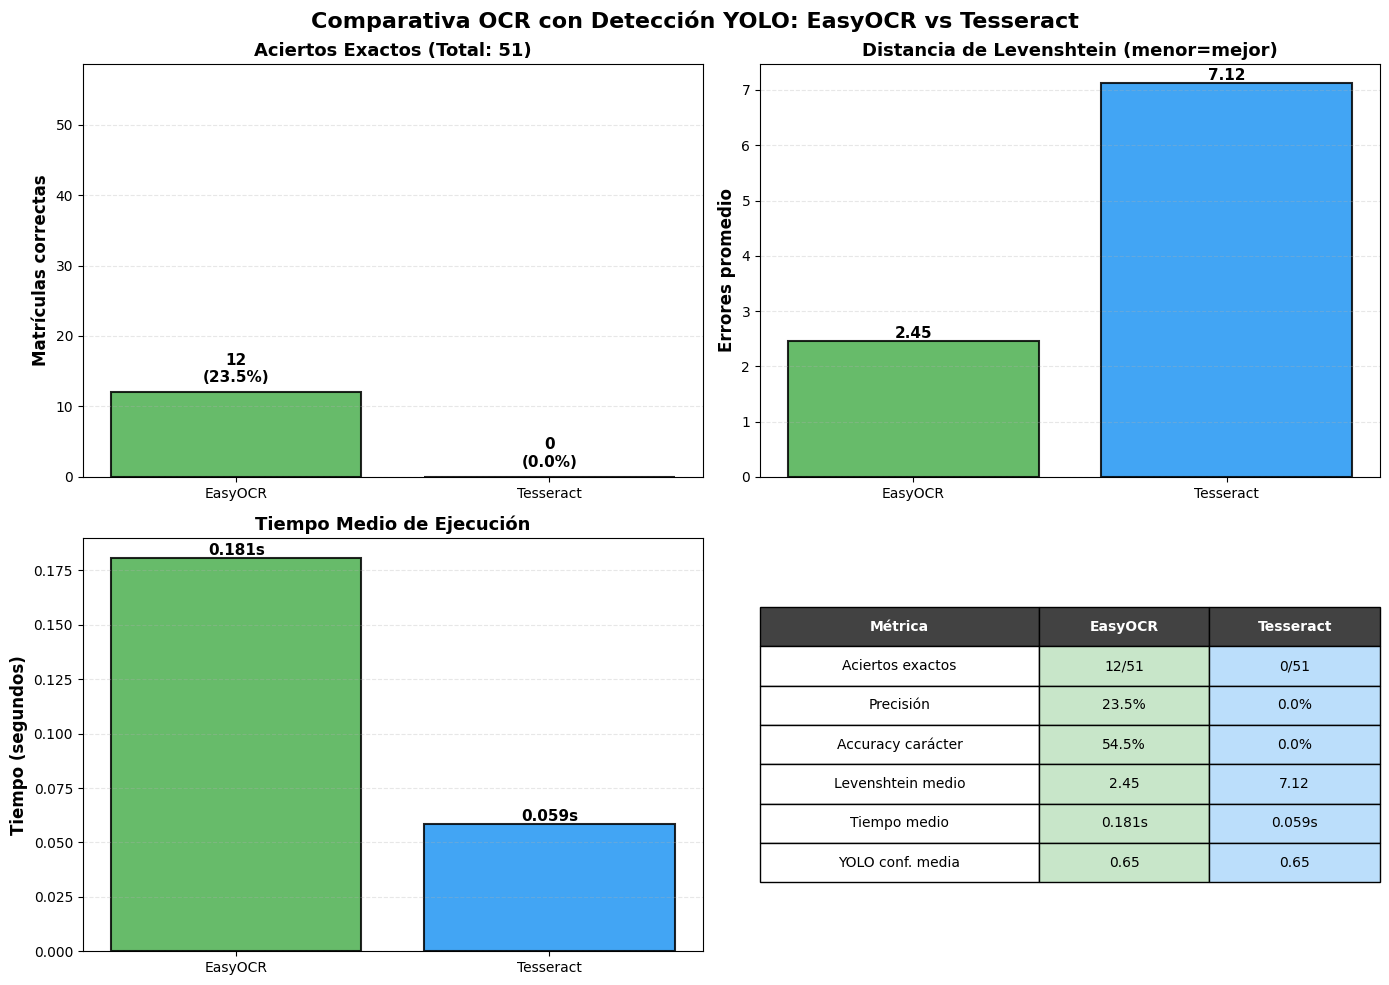

                 RESUMEN COMPARATIVO FINAL (con YOLO)                 

Total procesado: 51 imágenes
Detecciones exitosas YOLO: 51/57 (89.5%)
Confianza YOLO promedio: 0.65

Métrica                                EasyOCR       Tesseract
----------------------------------------------------------------------
Aciertos exactos:                        12/51            0/51
Precisión:                               23.5%            0.0%
Accuracy carácter:                       54.5%            0.0%
Levenshtein medio:                        2.45            7.12
Tiempo medio:                           0.181s          0.059s
----------------------------------------------------------------------

🏆 GANADOR: EasyOCR
   • 12 aciertos más que Tesseract (+23.5%)
   • 23.5% de precisión global

⚡ Tesseract es 0.122s más rápido en promedio

✅ Análisis completado con detección YOLO


In [2]:
"""
Tarea 2: Comparativa OCR (EasyOCR vs Tesseract) - Con detección YOLO
Usa el modelo YOLO entrenado para detectar matrículas automáticamente
"""

import cv2
import pytesseract
from pytesseract import Output
import easyocr
import torch
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
from pathlib import Path
import pandas as pd

# =================== CONFIGURACIÓN ===================
DATASET_DIR = r"C:\Users\User\Matriculas"
LABELS_DIR = os.path.join(DATASET_DIR, "labels")  # Subcarpeta labels
YOLO_MODEL_PATH = r"C:\Users\User\VC-ULPGC\VC_P4\P4\best.pt"  # Ruta al modelo YOLO entrenado
OCR_LANG = "en"
TESSERACT_PATH = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
OUTPUT_DIR = "ocr_comparison_results"
RESULTS_CSV = os.path.join(OUTPUT_DIR, "comparativa_ocr_yolo.csv")
SAVE_EXAMPLES = True  # Guardar ejemplos visuales
CONFIDENCE_THRESHOLD = 0.25  # Umbral de confianza para detecciones YOLO
# ====================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {device.upper()}")

pytesseract.pytesseract.tesseract_cmd = TESSERACT_PATH
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "ejemplos"), exist_ok=True)

# Cargar modelos
print("Cargando YOLO...")
yolo_model = YOLO(YOLO_MODEL_PATH)
print("✓ YOLO cargado")

print("Cargando EasyOCR...")
reader = easyocr.Reader([OCR_LANG], gpu=(device == 'cuda'))
print("✓ EasyOCR cargado\n")

# =================== UTILIDADES ===================
def clean_text(text):
    """Limpia texto dejando solo alfanuméricos"""
    return re.sub(r"[^A-Z0-9]", "", text.upper())

def fix_common_errors(text):
    """Corrige errores OCR comunes"""
    text = text.replace('O', '0').replace('I', '1').replace('L', '1')
    text = text.replace('S', '5').replace('Z', '2')
    return text

def try_fix_order(text, ground_truth):
    """Intenta corregir el orden si está invertido"""
    if len(text) < 5:
        return text
    
    patterns = []
    
    if len(text) >= 7:
        nums = ''.join(c for c in text if c.isdigit())
        lets = ''.join(c for c in text if c.isalpha())
        
        if len(nums) >= 4 and len(lets) >= 3:
            patterns.append(nums[:4] + lets[:3])  # Normal
            patterns.append(lets[-3:] + nums[:4])  # Invertido
            
            # Canarias: GC + 4 nums + 2 lets
            if len(lets) >= 4 and len(nums) >= 4:
                patterns.append(lets[:2] + nums[:4] + lets[2:4])
    
    best = text
    best_score = 0
    
    for p in patterns:
        if len(p) == len(ground_truth):
            score = sum(1 for i, c in enumerate(p) if i < len(ground_truth) and c == ground_truth[i])
            if score > best_score:
                best_score = score
                best = p
    
    return best

def normalize_plate(text, ground_truth=""):
    """Normaliza matrícula española"""
    text = clean_text(text)
    text = fix_common_errors(text)
    
    if ground_truth:
        text = try_fix_order(text, ground_truth)
    
    valid_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    nums = ''.join(c for c in text if c.isdigit())
    lets = ''.join(c for c in text if c in valid_letters)
    
    # Formato estándar: 4 números + 3 letras
    if len(nums) >= 4 and len(lets) >= 3:
        return nums[:4] + lets[:3]
    
    # Formato Canarias: 2 letras + 4 números + 2 letras
    if len(lets) >= 4 and len(nums) >= 4:
        return lets[:2] + nums[:4] + lets[2:4]
    
    # Formato antiguo: 1 letra + 4 números + 3 letras
    if len(lets) >= 4 and len(nums) >= 4:
        return lets[0] + nums[:4] + lets[1:4]
    
    return text

def extract_ground_truth(filename):
    """Extrae ground truth del nombre"""
    return clean_text(Path(filename).stem)

def calculate_accuracy(predicted, ground_truth):
    """Precisión carácter por carácter"""
    if len(predicted) == 0 or len(ground_truth) == 0:
        return 0.0
    max_len = max(len(predicted), len(ground_truth))
    matches = sum(1 for i in range(max_len) 
                  if i < len(predicted) and i < len(ground_truth) 
                  and predicted[i] == ground_truth[i])
    return (matches / max_len) * 100

def calculate_levenshtein(s1, s2):
    """Distancia de Levenshtein"""
    if len(s1) < len(s2):
        return calculate_levenshtein(s2, s1)
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def detect_plate_yolo(img_path):
    """Detecta matrícula usando YOLO y devuelve bbox"""
    try:
        results = yolo_model.predict(img_path, conf=CONFIDENCE_THRESHOLD, verbose=False)
        
        if len(results) > 0 and len(results[0].boxes) > 0:
            # Tomar la detección con mayor confianza
            boxes = results[0].boxes
            best_idx = boxes.conf.argmax()
            box = boxes.xyxy[best_idx].cpu().numpy()
            conf = boxes.conf[best_idx].item()
            
            x1, y1, x2, y2 = map(int, box)
            return x1, y1, x2, y2, conf
    except Exception as e:
        print(f"    ⚠ Error en detección YOLO: {e}")
    
    return None

# =================== PROCESAMIENTO OCR ===================
def process_image_ocr(img_path, ground_truth, save_example=False):
    """Procesa imagen con YOLO + OCR"""
    
    img = cv2.imread(img_path)
    if img is None:
        return None
    
    # Detectar matrícula con YOLO
    detection = detect_plate_yolo(img_path)
    if detection is None:
        print(f"    ⚠ No se detectó matrícula")
        return None
    
    x1, y1, x2, y2, conf = detection
    
    # Recorte condicional de banda azul 'E'
    x1_new = x1
    if ground_truth and ground_truth[0].isdigit():
        plate_width = x2 - x1
        x1_new = x1 + int(plate_width * 0.12)
    
    crop = img[y1:y2, x1_new:x2].copy()
    
    if crop.size == 0:
        return None
    
    # Resize x3
    crop_resized = cv2.resize(crop, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    
    # --- EASYOCR ---
    start_time = time.time()
    easy_raw = ""
    try:
        results = reader.readtext(crop_resized, paragraph=True, detail=0)
        easy_raw = " ".join(results).upper()
    except:
        pass
    
    easy_norm = normalize_plate(easy_raw, ground_truth)
    easy_time = time.time() - start_time
    
    # --- TESSERACT ---
    gray = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2GRAY)
    _, enhanced = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    tess_config = '--oem 1 --psm 7 -l spa -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    
    start_time = time.time()
    tess_raw = ""
    try:
        tess_result = pytesseract.image_to_string(enhanced, config=tess_config).strip()
        tess_raw = tess_result.upper()
    except:
        pass
    
    tess_norm = normalize_plate(tess_raw, ground_truth)
    tess_time = time.time() - start_time
    
    # Guardar ejemplo visual
    if save_example:
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        
        # Original con bbox YOLO
        img_vis = img.copy()
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_vis, f'{conf:.2f}', (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        axes[0].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'YOLO Detection - GT: {ground_truth}')
        axes[0].axis('off')
        
        # Crop resize
        axes[1].imshow(cv2.cvtColor(crop_resized, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Crop x3 - EasyOCR: {easy_norm}')
        axes[1].axis('off')
        
        # Resultados
        easy_color = 'green' if easy_norm == ground_truth else 'red'
        tess_color = 'green' if tess_norm == ground_truth else 'red'
        
        axes[2].text(0.5, 0.7, f'Ground Truth:\n{ground_truth}', 
                    ha='center', va='center', fontsize=14, fontweight='bold')
        axes[2].text(0.5, 0.45, f'EasyOCR:\n{easy_norm}', 
                    ha='center', va='center', fontsize=12, color=easy_color, fontweight='bold')
        axes[2].text(0.5, 0.25, f'Tesseract:\n{tess_norm}', 
                    ha='center', va='center', fontsize=12, color=tess_color, fontweight='bold')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/ejemplos/{Path(img_path).stem}.png", dpi=120)
        plt.close()
    
    return {
        'imagen': Path(img_path).name,
        'ground_truth': ground_truth,
        'yolo_confidence': conf,
        'easy_raw': easy_raw,
        'easy_normalized': easy_norm,
        'easy_correct': (easy_norm == ground_truth),
        'easy_accuracy': calculate_accuracy(easy_norm, ground_truth),
        'easy_levenshtein': calculate_levenshtein(easy_norm, ground_truth),
        'easy_time': easy_time,
        'tess_raw': tess_raw,
        'tess_normalized': tess_norm,
        'tess_correct': (tess_norm == ground_truth),
        'tess_accuracy': calculate_accuracy(tess_norm, ground_truth),
        'tess_levenshtein': calculate_levenshtein(tess_norm, ground_truth),
        'tess_time': tess_time
    }

# =================== PROCESAMIENTO DATASET ===================
print("Buscando imágenes con labels correspondientes...\n")

# Buscar archivos .txt en la carpeta labels
label_files = [f for f in os.listdir(LABELS_DIR) 
               if f.endswith('.txt') and f != 'classes.txt']

# Emparejar imágenes con sus labels
image_files = []
for label_file in label_files:
    base_name = Path(label_file).stem
    for ext in ['.jpg', '.jpeg', '.JPG', '.JPEG', '.png', '.PNG']:
        img_path = Path(DATASET_DIR) / (base_name + ext)
        if img_path.exists():
            image_files.append(img_path)
            break

total = len(image_files)
print(f"✓ Encontradas {total} imágenes con labels correspondientes\n")
print("="*70)

results_list = []
failed_detections = 0

for idx, img_path in enumerate(image_files, 1):
    ground_truth = extract_ground_truth(img_path.name)
    
    # Guardar ejemplos visuales solo para las primeras 15
    save_ex = SAVE_EXAMPLES and idx <= 15
    
    result = process_image_ocr(str(img_path), ground_truth, save_ex)
    
    if result:
        results_list.append(result)
        
        easy_icon = '✓' if result['easy_correct'] else '✗'
        tess_icon = '✓' if result['tess_correct'] else '✗'
        
        print(f"[{idx}/{total}] {img_path.name}")
        print(f"  GT: {ground_truth} | YOLO conf: {result['yolo_confidence']:.2f}")
        print(f"  EasyOCR:   {result['easy_normalized']:12s} {easy_icon}  "
              f"(Acc: {result['easy_accuracy']:5.1f}%, {result['easy_time']:.3f}s)")
        print(f"  Tesseract: {result['tess_normalized']:12s} {tess_icon}  "
              f"(Acc: {result['tess_accuracy']:5.1f}%, {result['tess_time']:.3f}s)")
        print()
    else:
        failed_detections += 1

# =================== GUARDAR RESULTADOS ===================
df = pd.DataFrame(results_list)
df.to_csv(RESULTS_CSV, index=False, encoding='utf-8-sig')

print("="*70)
print(f"✓ Resultados guardados: {RESULTS_CSV}")
print(f"✓ Procesadas: {len(results_list)}/{total} imágenes")
print(f"⚠ Detecciones fallidas: {failed_detections}")
print("="*70 + "\n")

# =================== ESTADÍSTICAS ===================
if len(results_list) == 0:
    print("❌ No hay resultados para analizar")
    exit()

easy_correct = df['easy_correct'].sum()
tess_correct = df['tess_correct'].sum()

easy_avg_acc = df['easy_accuracy'].mean()
tess_avg_acc = df['tess_accuracy'].mean()

easy_avg_lev = df['easy_levenshtein'].mean()
tess_avg_lev = df['tess_levenshtein'].mean()

easy_avg_time = df['easy_time'].mean()
tess_avg_time = df['tess_time'].mean()

yolo_avg_conf = df['yolo_confidence'].mean()

# =================== GRÁFICAS ===================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparativa OCR con Detección YOLO: EasyOCR vs Tesseract', 
             fontsize=16, fontweight='bold')

colors = ['#4CAF50', '#2196F3']

# 1. Aciertos exactos
ax1 = axes[0, 0]
bars = ax1.bar(['EasyOCR', 'Tesseract'], [easy_correct, tess_correct], 
               color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Matrículas correctas', fontsize=12, fontweight='bold')
ax1.set_title(f'Aciertos Exactos (Total: {len(results_list)})', fontsize=13, fontweight='bold')
ax1.set_ylim(0, len(results_list) * 1.15)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, [easy_correct, tess_correct]):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{val}\n({val/len(results_list)*100:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. Levenshtein
ax2 = axes[0, 1]
bars = ax2.bar(['EasyOCR', 'Tesseract'], [easy_avg_lev, tess_avg_lev],
               color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Errores promedio', fontsize=12, fontweight='bold')
ax2.set_title('Distancia de Levenshtein (menor=mejor)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, [easy_avg_lev, tess_avg_lev]):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Tiempo
ax3 = axes[1, 0]
bars = ax3.bar(['EasyOCR', 'Tesseract'], [easy_avg_time, tess_avg_time],
               color=colors, alpha=0.85, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Tiempo (segundos)', fontsize=12, fontweight='bold')
ax3.set_title('Tiempo Medio de Ejecución', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3, linestyle='--')
for bar, val in zip(bars, [easy_avg_time, tess_avg_time]):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.3f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Tabla resumen
ax4 = axes[1, 1]
ax4.axis('off')
summary = [
    ['Métrica', 'EasyOCR', 'Tesseract'],
    ['Aciertos exactos', f'{easy_correct}/{len(results_list)}', f'{tess_correct}/{len(results_list)}'],
    ['Precisión', f'{easy_correct/len(results_list)*100:.1f}%', f'{tess_correct/len(results_list)*100:.1f}%'],
    ['Accuracy carácter', f'{easy_avg_acc:.1f}%', f'{tess_avg_acc:.1f}%'],
    ['Levenshtein medio', f'{easy_avg_lev:.2f}', f'{tess_avg_lev:.2f}'],
    ['Tiempo medio', f'{easy_avg_time:.3f}s', f'{tess_avg_time:.3f}s'],
    ['YOLO conf. media', f'{yolo_avg_conf:.2f}', f'{yolo_avg_conf:.2f}']
]

table = ax4.table(cellText=summary, cellLoc='center', loc='center',
                  colWidths=[0.45, 0.275, 0.275])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.0)

for i in range(len(summary)):
    for j in range(3):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#424242')
            cell.set_text_props(weight='bold', color='white')
        else:
            if j == 1:
                cell.set_facecolor('#C8E6C9')
            elif j == 2:
                cell.set_facecolor('#BBDEFB')

plt.tight_layout()
graph_path = os.path.join(OUTPUT_DIR, 'comparativa_grafica_yolo.png')
plt.savefig(graph_path, dpi=150, bbox_inches='tight')
print(f"✓ Gráfica guardada: {graph_path}\n")
plt.show()

# =================== RESUMEN FINAL ===================
print("="*70)
print("RESUMEN COMPARATIVO FINAL (con YOLO)".center(70))
print("="*70)
print(f"\nTotal procesado: {len(results_list)} imágenes")
print(f"Detecciones exitosas YOLO: {len(results_list)}/{total} ({len(results_list)/total*100:.1f}%)")
print(f"Confianza YOLO promedio: {yolo_avg_conf:.2f}\n")
print(f"{'Métrica':<30} {'EasyOCR':>15} {'Tesseract':>15}")
print("-"*70)
print(f"{'Aciertos exactos:':<30} {f'{easy_correct}/{len(results_list)}':>15} {f'{tess_correct}/{len(results_list)}':>15}")
print(f"{'Precisión:':<30} {f'{easy_correct/len(results_list)*100:.1f}%':>15} {f'{tess_correct/len(results_list)*100:.1f}%':>15}")
print(f"{'Accuracy carácter:':<30} {f'{easy_avg_acc:.1f}%':>15} {f'{tess_avg_acc:.1f}%':>15}")
print(f"{'Levenshtein medio:':<30} {f'{easy_avg_lev:.2f}':>15} {f'{tess_avg_lev:.2f}':>15}")
print(f"{'Tiempo medio:':<30} {f'{easy_avg_time:.3f}s':>15} {f'{tess_avg_time:.3f}s':>15}")
print("-"*70)

if easy_correct > tess_correct:
    diff = easy_correct - tess_correct
    print(f"\n🏆 GANADOR: EasyOCR")
    print(f"   • {diff} aciertos más que Tesseract (+{diff/len(results_list)*100:.1f}%)")
    print(f"   • {easy_correct/len(results_list)*100:.1f}% de precisión global")
elif tess_correct > easy_correct:
    diff = tess_correct - easy_correct
    print(f"\n🏆 GANADOR: Tesseract")
    print(f"   • {diff} aciertos más que EasyOCR (+{diff/len(results_list)*100:.1f}%)")
else:
    print(f"\n🤝 EMPATE en aciertos exactos")

time_diff = abs(easy_avg_time - tess_avg_time)
faster = "EasyOCR" if easy_avg_time < tess_avg_time else "Tesseract"
print(f"\n⚡ {faster} es {time_diff:.3f}s más rápido en promedio")

print("\n" + "="*70)
print("✅ Análisis completado con detección YOLO")